In [68]:
import os
import sys
import random
import warnings
import datetime, os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label



from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout, Lambda, Flatten, Activation
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, Adadelta, RMSprop
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Dropout, Flatten, Reshape, Dense
import tensorflow as tf


import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

from skimage.io import imread, imshow
from skimage.transform import resize

# Don't Show Warning Messages
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import six

from random import randint

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from skimage.transform import resize


from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout,BatchNormalization
from tensorflow.keras.layers import Conv2D, Concatenate, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import UpSampling2D, Dropout, BatchNormalization
from tqdm import tqdm_notebook
from tensorflow.keras import initializers
from tensorflow.keras import regularizers #Activation,SpatialDropout2D
from tensorflow.keras import constraints
from tensorflow.keras import backend as K
#from tensorflow.keras.applications.imagenet_utils import _obtain_input_shape
from tensorflow.keras.regularizers import l2


In [69]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3

NUM_TEST_IMAGES = 30

In [70]:
images = os.listdir('D:/kvasir_segmentation_dataset/kvasir_segmentation_dataset/images')
masks = os.listdir('D:/kvasir_segmentation_dataset/kvasir_segmentation_dataset/masks')


In [4]:
# create a dataframe
df_images = pd.DataFrame(images, columns=['image_id'])
## example filename: cju0qkwl35piu0993l0dewei2.jpg

def get_num_cells(x):
    # split on the _
    a = x
    # choose the third item
    # choose second item onwards and convert to int
    num_cells = (a[1:])
    
    return num_cells

# create a new column called 'num_cells'
df_images['num_cells'] = df_images['image_id'].apply(get_num_cells)

def check_for_mask(x):
    if x in masks:
        return 'yes'
    else:
        return 'no'
    
# create a new column called 'has_mask'
df_images['has_mask'] = df_images['image_id'].apply(check_for_mask)

df_images.head(10)
df_images ['has_mask']



0      yes
1      yes
2      yes
3      yes
4      yes
      ... 
995    yes
996    yes
997    yes
998    yes
999    yes
Name: has_mask, Length: 1000, dtype: object

In [5]:
#Checking if every image has a mask.
df_images['has_mask'].value_counts()

yes    1000
Name: has_mask, dtype: int64

In [6]:
df_masks = df_images[df_images['has_mask'] == 'yes']

# create a new column called mask_id that is just a copy of image_id
df_masks['mask_id'] = df_masks['image_id']

df_masks.shape

(1000, 4)

In [7]:
# create a test set
df_test = df_masks.sample(NUM_TEST_IMAGES, random_state=101)

# Reset the index.
# This is so that we can use loc to access mask id's later.
df_test = df_test.reset_index(drop=True)

# create a list of test images
test_images_list = list(df_test['image_id'])


# Select only rows that are not part of the test set.
# Note the use of ~ to execute 'not in'.
df_masks = df_masks[~df_masks['image_id'].isin(test_images_list)]

print(df_masks.shape)
print(df_test.shape)

(970, 4)
(30, 4)


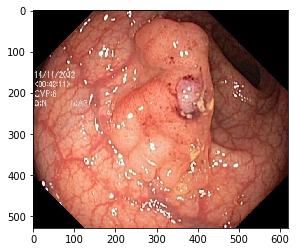

In [8]:
sample_image = 'cju0qx73cjw570799j4n5cjze.jpg'
path_image = 'D:/kvasir_segmentation_dataset/kvasir_segmentation_dataset/images/' + sample_image

# read the image using skimage
image = imread(path_image)

plt.imshow(image)

In [9]:
print('Shape: ', image.shape)
print('Max pixel value: ', image.max())
print('Min pixel value: ', image.min())

Shape:  (529, 619, 3)
Max pixel value:  255
Min pixel value:  0


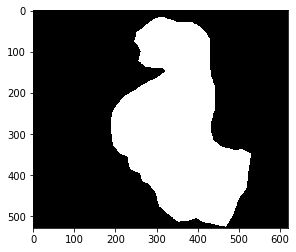

In [10]:
sample_mask = 'cju0qx73cjw570799j4n5cjze.jpg'
path_mask = 'D:/kvasir_segmentation_dataset/kvasir_segmentation_dataset/masks/' + sample_mask

# read the mask using skimage
mask = imread(path_mask)

plt.imshow(mask, cmap='gray')

In [11]:
print('Shape: ', mask.shape)
print('Max pixel value: ', mask.max())
print('Min pixel value: ', mask.min())

Shape:  (529, 619, 3)
Max pixel value:  255
Min pixel value:  0


In [12]:
# Get lists of images and their masks.
image_id_list = list(df_masks['image_id'])
mask_id_list = list(df_masks['mask_id'])
test_id_list = list(df_test['image_id'])

# Create empty arrays

X_train = np.zeros((len(image_id_list), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)

Y_train = np.zeros((len(image_id_list), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)

X_test = np.zeros((NUM_TEST_IMAGES, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)

In [13]:
# X_train

for i, image_id in enumerate(image_id_list):
    
    path_image = 'D:/kvasir_segmentation_dataset/kvasir_segmentation_dataset/images/' + image_id
    
    # read the image using skimage
    image = imread(path_image)
    
    # resize the image
    image = resize(image, (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), mode='constant', preserve_range=True)
    


    
    # insert the image into X_train
    X_train[i] = image
    
X_train.shape

(970, 128, 128, 3)

In [14]:
# Y_train

for i, mask_id in enumerate(mask_id_list):
    
    path_mask = 'D:/kvasir_segmentation_dataset/kvasir_segmentation_dataset/masks/' + mask_id
    
    # read the image using skimage
    mask = imread(path_mask)
    
    # resize the image
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), mode='constant', preserve_range=True)
    
    # use np.expand dims to add a channel axis so the shape becomes (IMG_HEIGHT, IMG_WIDTH, 1)
    #mask = np.expand_dims(mask, axis=-1)
    
    # insert the image into Y_Train
    Y_train[i] = mask

Y_train.shape

(970, 128, 128, 3)

In [15]:
# X_test

for i, image_id in enumerate(test_id_list):
    
    path_image = 'D:/kvasir_segmentation_dataset/kvasir_segmentation_dataset/images/' + image_id
    
    # read the image using skimage
    image = imread(path_image)
    
    # resize the image
    image = resize(image, (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), mode='constant', preserve_range=True)
    
    # use np.expand dims to add a channel axis so the shape becomes (IMG_HEIGHT, IMG_WIDTH, 1)
    #image = np.expand_dims(image, axis=-1)
    
    # insert the image into X_test
    X_test[i] = image
    
X_test.shape

(30, 128, 128, 3)

In [18]:
X_train = np.append(X_train, [np.fliplr(x) for x in X_train], axis=0)
Y_train = np.append(Y_train, [np.fliplr(x) for x in Y_train], axis=0)

In [110]:
def standard_unit(input_tensor, stage, nb_filter, kernel_size=3):

    act = 'elu'

    x = Conv2D(nb_filter, (kernel_size, kernel_size), activation=act, name='conv'+stage+'_1', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(input_tensor)
    x = Dropout(dropout_rate, name='dp'+stage+'_1')(x)
    x = Conv2D(nb_filter, (kernel_size, kernel_size), activation=act, name='conv'+stage+'_2', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(dropout_rate, name='dp'+stage+'_2')(x)

    return x
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [111]:
def Nest_Net(img_rows, img_cols, color_type=1, num_class=1, deep_supervision=False):

    nb_filter = [32,64,128,256,512]
    act = 'elu'

    bn_axis = 3
    img_input = Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), name='main_input')

    conv1_1 = standard_unit(img_input, stage='11', nb_filter=nb_filter[0])
    pool1 = MaxPool2D((2, 2), strides=(2, 2), name='pool1')(conv1_1)

    conv2_1 = standard_unit(pool1, stage='21', nb_filter=nb_filter[1])
    pool2 = MaxPool2D((2, 2), strides=(2, 2), name='pool2')(conv2_1)

    up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(conv2_1)
    conv1_2 = concatenate([up1_2, conv1_1], name='merge12', axis=bn_axis)
    conv1_2 = standard_unit(conv1_2, stage='12', nb_filter=nb_filter[0])

    conv3_1 = standard_unit(pool2, stage='31', nb_filter=nb_filter[2])
    pool3 = MaxPool2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

    up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
    conv2_2 = concatenate([up2_2, conv2_1], name='merge22', axis=bn_axis)
    conv2_2 = standard_unit(conv2_2, stage='22', nb_filter=nb_filter[1])

    up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
    conv1_3 = concatenate([up1_3, conv1_1, conv1_2], name='merge13', axis=bn_axis)
    conv1_3 = standard_unit(conv1_3, stage='13', nb_filter=nb_filter[0])

    conv4_1 = standard_unit(pool3, stage='41', nb_filter=nb_filter[3])
    pool4 = MaxPool2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

    up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
    conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=bn_axis)
    conv3_2 = standard_unit(conv3_2, stage='32', nb_filter=nb_filter[2])

    up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
    conv2_3 = concatenate([up2_3, conv2_1, conv2_2], name='merge23', axis=bn_axis)
    conv2_3 = standard_unit(conv2_3, stage='23', nb_filter=nb_filter[1])

    up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
    conv1_4 = concatenate([up1_4, conv1_1, conv1_2, conv1_3], name='merge14', axis=bn_axis)
    conv1_4 = standard_unit(conv1_4, stage='14', nb_filter=nb_filter[0])

    conv5_1 = standard_unit(pool4, stage='51', nb_filter=nb_filter[4])

    up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
    conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=bn_axis)
    conv4_2 = standard_unit(conv4_2, stage='42', nb_filter=nb_filter[3])

    up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
    conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=bn_axis)
    conv3_3 = standard_unit(conv3_3, stage='33', nb_filter=nb_filter[2])

    up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
    conv2_4 = concatenate([up2_4, conv2_1, conv2_2, conv2_3], name='merge24', axis=bn_axis)
    conv2_4 = standard_unit(conv2_4, stage='24', nb_filter=nb_filter[1])

    up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
    conv1_5 = concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], name='merge15', axis=bn_axis)
    conv1_5 = standard_unit(conv1_5, stage='15', nb_filter=nb_filter[0])

    nestnet_output_1 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_1', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_2)
    nestnet_output_2 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_2', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_3)
    nestnet_output_3 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_3', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_4)
    nestnet_output_4 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_4', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_5)

    if deep_supervision:
        model = Model(img_input, [nestnet_output_1,nestnet_output_2,nestnet_output_3,nestnet_output_4])
    else:
        model = Model(img_input, [nestnet_output_4])
    
    return model


In [112]:
# Dice similarity coefficient loss, brought to you by: https://github.com/nabsabraham/focal-tversky-unet
def dsc(y_true, y_pred):
    smooth = 1.
    y_true_f = Flatten()(y_true)
    y_pred_f = Flatten()(y_pred)
    intersection = reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (reduce_sum(y_true_f) + reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dsc(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

In [117]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

tf.compat.v1.disable_eager_execution()


tfd = tfp.distributions

init = tf.compat.v1.global_variables_initializer()

with tf.compat.v1.Session() as sess:
    sess.run(init)

    model = tf.keras.Sequential([
      tf.keras.layers.Dense(1,kernel_initializer='glorot_uniform'),
      tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1))
    ])
# get an instance of the model
model = Nest_Net(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, num_class=2, deep_supervision=False)
# define optimizer 
adam = Adam(lr = 0.05, epsilon = 0.1)
model.compile(optimizer=adam, loss=bce_dice_loss, metrics=[dice_loss])

AttributeError: module 'tensorflow_core.compat.v1.compat' has no attribute 'v1'

ModuleNotFoundError: No module named 'efficientnet'

W1014 21:21:51.602864  1904 deprecation.py:323] From C:\Users\zakel\Anaconda3\lib\site-packages\tensorflow_core\python\compat\v2_compat.py:65: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
Instructions for updating:
non-resource variables are not supported in the long term


AttributeError: module 'tensorflow' has no attribute 'placeholder'